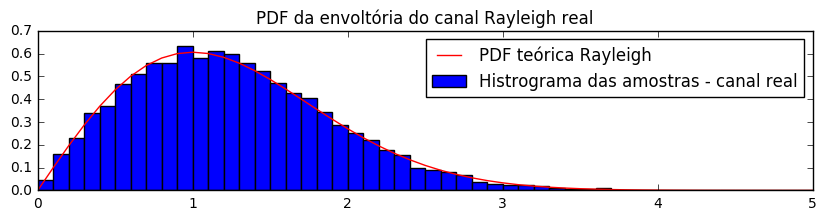

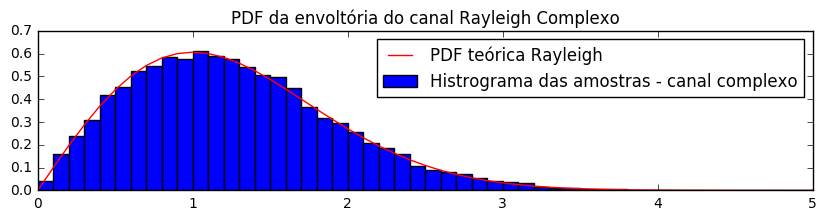

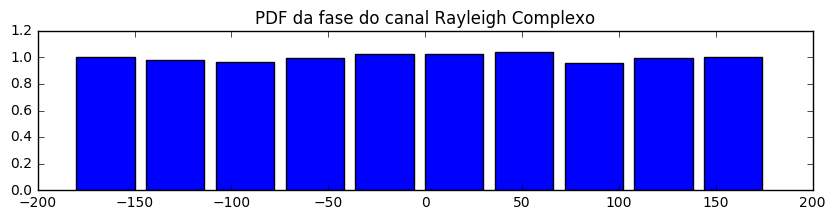

In [1]:
%
% Parâmetros
N = 20000;                                  % Número de amostras
ts = 0.1;
x=0:ts:5+ts;                     % Eixo x
sigma = 1;                                  % Parâmetro Rayleigh
u = randn(N);                      % Amostras aleatórias uniformemente distribuídas de 0 a 1
%
% Canal Rayleigh real via método da inversão
rReal = sigma*sqrt(-2*log(u));        % Rayleigh via método da inversão
%
% PDF Rayleigh teórico 
pdfTeo = x./(sigma^2).*exp(-(x/sigma)^2/2);
% 
% Canal Rayleigh complexo via VAs Gaussianas independentes
rComplexo = randn(N)+i*randn(N);
%
% Gráficos
subplot(3,1,1);
% Histograma do Canal real vs PDF teórica
[xh, temp]=histogram(rReal,x);
temp = temp(1:end-1);
width = ts;
bar(temp,xh/(sum(xh)*ts),width,label='Histrograma das amostras - canal real');
%
% PDF teórica
plot(x,pdfTeo,'r', label='PDF teórica Rayleigh');
%
title('PDF da envoltória do canal Rayleigh real');
legend();
show();
%
% Envoltória do Canal complexo
subplot(3,1,2);
% Histograma da envoltória do canal complexo vs PDF teórica
[xh, temp]=histogram(abs(rComplexo),x);
temp = temp(1:end-1);
width = ts;
bar(temp,xh/(sum(xh)*ts),width,label='Histrograma das amostras - canal complexo');
%
% PDF teórica
plot(x,pdfTeo,'r', label='PDF teórica Rayleigh');
%
title('PDF da envoltória do canal Rayleigh Complexo');
legend();
show();
% Histrograma da Fase do Canal complexo
subplot(3,1,3);
[xhra, tempra]=histogram(angle(rComplexo));
tempra = tempra(1:end-1);
bar(180/pi*tempra,xhra/(sum(xhra)*ts),width=30);
title('PDF da fase do canal Rayleigh Complexo');

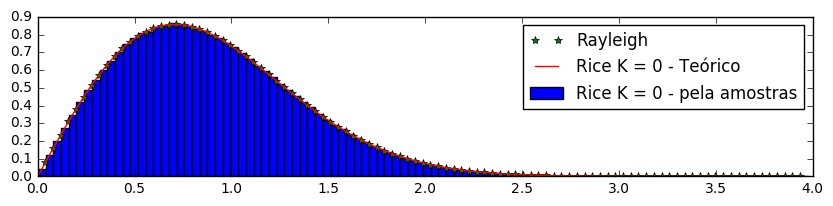

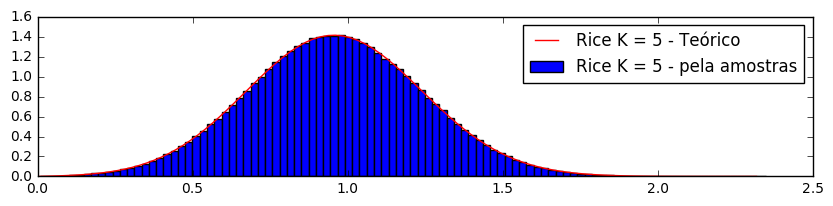

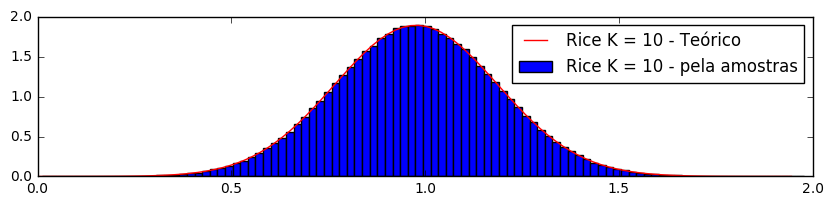

In [2]:
N = 1000000;                                        % Número de amostras a gerar
vtK = [0 5 10];                                   % Fatores K Ricianos a simular
totPower=1;                                          % Total power of LOS path & scattered paths
%
% Loop nos valores de K
for ik=1:length(vtK)
    K = vtK(ik);
    s=sqrt(K/(K+1)*totPower);                     % Parâmetro de não centralidade
    sigma=totPower/sqrt(2*(K+1));
    % Amostras do Canal Rice
    X = s + sigma*randn(N);                % LOS: VA Gaussina com média=s e sigma definido
    Y = 0 + sigma*randn(N);                % NLOS: VA Gaussina com média=0 e sigma definido
    Z = X + 1j*Y;
    [val bins]=histogram(abs(Z),bins=100);     % Histograma de Z
    bins = bins(1:end-1);                      % Ajuste do eixo
    %
    % PDF Rice teórica
    binWidth = bins(3)-bins(2);
    r = 0:max(bins):binWidth;
    figure;
    hold all;
    subplot(len(vtK),1,ik);
    % PDF teórica Rayleigh (para comparação)    
    if K == 0
        rayleigh_pdf = r./(sigma^2).*exp(-r^2./(2*sigma**2));
        plot(r,rayleigh_pdf,'g*', label = 'Rayleigh');
    end
    fRice = 2*r.*(K+1)/totPower.*exp(-r**2.*(K+1)/totPower-K).*besselI(0,2*r*sqrt(K*(K+1)/totPower));
    % Gráficos
    bar(bins,val/(binWidth*sum(val)),binWidth, label=['Rice K =' num2str(k) '- pela amostras');
    plot(r,fRice,'r',label=['Rice K = ' num2str(K) '- Teórico');
    legend();
    show();
end

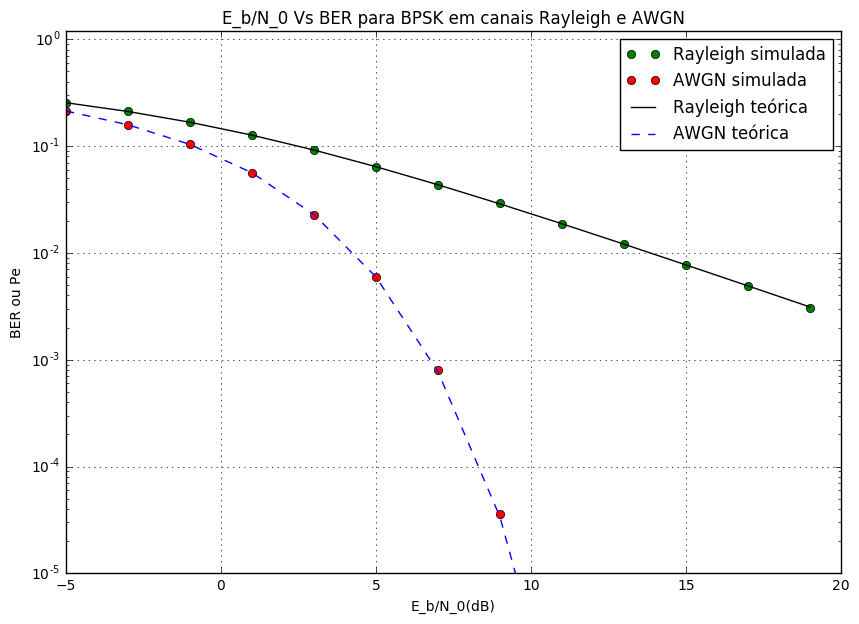

In [3]:
% Parâmetros
N = 10^6;                       % Número de símbolos BPSK a serem transmitidos
EbN0dB = -5:20:2;     % Valores EbN0 a simular
% Transmissor
d = randn(N) > 0.5;     % Dados binários 
x = 2.*d -1;             % Símbolos BPSK: 0 representado por -1 e 1 representado por 1
%
% Inicialização de vetores de BER simulada e teórica
BER_rayleigh_simulada = zeros(length(EbN0dB));
BER_awgn_simulada = zeros(length(EbN0dB));
%
% Loop de EbNo
for ik=1:range(length(EbN0dB))
    % Canal
    % Ruído AWGN complexo com média 0 e variância 1 (vetor base)
    noise = 1/sqrt(2).*(randn(N)+i*randn(N));
    % Vetor de ruído com potência proporcional a EbNo corrente
    n = noise.*10^(-EbN0dB(ik)/20);
    % Desvanecimento Rayleigh normalizado
    h = 1/sqrt(2).*(randn(N)+i*randn(N));
    %
    % Sinal recebido para caso com somente ruído AWGN
    y_awgn = x + n;
    % Sinal recebido para caso com desvanecimento Rayleigh e ruído AWGN
    y_rayleigh = h.*x + n;
    %
    % Receptor coerente para o canal Rayleigh (supondo conhecimento de h no receptor)
    y_rayleigh_cap=y_rayleigh/h; % Equalizador
    % Os símbolos positivos recebidos são 1, os demais são 0 (lembrar da simbologia)
    r_rayleigh = real(y_rayleigh_cap)>0;
    %
    % Receptor para o canal somente AWGN
    r_awgn = real(y_awgn) > 0;
    % Contador de erro para o caso com Rayleigh e AWGN
    BER_rayleigh_simulada(ik) = sum(bitxor(d,r_rayleigh));
    % Contador de erro para o caso com somente AWGN
    BER_awgn_simulada(ik) = sum(bitxor(d,r_awgn));
    % Fim do loop de EbN0
end
% Cálculo da BER para o caso com Rayleigh e AWGN
BER_rayleigh_simulada = BER_rayleigh_simulada./N;
% Cálculo da BER para o caso com somente AWGN
BER_awgn_simulada = BER_awgn_simulada./N;
%
% Pe Teórica
EbN0=10^(EbN0dB/10);            % Eb/N0 em escala linear
% Implementação direta da equação de Pe para o canal Rayleigh+AWGN
BER_rayleigh_teorica = 0.5*(1-sqrt(EbN0/(1+EbN0)));
% Implementação direta da equação de Pe para o canal somente AWGN
BER_awgn_teorica = 0.5*erfc(sqrt(EbN0));
%
% Gráficos
figure
% Rayleigh simulado
semilogy(EbN0dB,BER_rayleigh_simulada,'go',label='Rayleigh simulada')
% AWGN simulado
semilogy(EbN0dB,BER_awgn_simulada,'ro',label='AWGN simulada')
% Rayleigh teórico
semilogy(EbN0dB,BER_rayleigh_teorica,'k-',label='Rayleigh teórica')
% AWGN teórico
semilogy(EbN0dB,BER_awgn_teorica,'b--',label='AWGN teórica')
axis([-5 20 10^(-5) 1.2])
legend()
title('E_b/N_0 Vs BER para BPSK em canais Rayleigh e AWGN')
xlabel('E_b/N_0(dB)')
ylabel('BER ou Pe')

Simulando K = 0
Simulando K = 5
Simulando K = 30


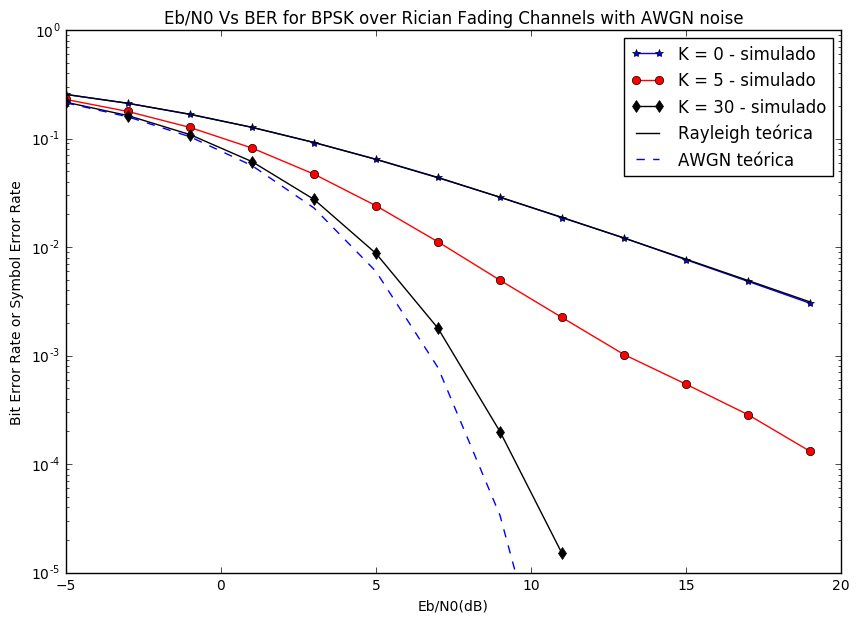

In [5]:
%
% Parâmetros
N = 10^6                          % Número de símbolos BPSK a serem transmitidos
EbN0dB = -5:20:2                  % Valores EbN0 a simular
EbN0=10^(EbN0dB/10)               % EbN0 em escala linear
totPower=1                         % Potência total (LOS + NLOS)
K=[0 5 30]               % Valores K Ricianos a simular
% Transmissor
d=randn(N)>0.5            % Dados binários 
x = 2*d -1                         % Símbolos BPSK: 0 representado por -1 e 1 representado por 1
%
% Inicialização de vetores de BER simulada e teórica
simBER_ricean=zeros(1, length(EbN0dB))
% Configuração da figuras e linhas
figure
plotStyleSim=['b-*' 'r-o' 'k-d' 'g-^' 'm->' 'c-<']
%
% Loop de K Riciano
for index=1:length(K)
    k = K[index]                   % Valor de K corrente
    % Mensagem de progresso da simulação
    disp(['Simulando K = ' num2str(k)])
    % Canal
    % Parâmetro de não-centralidade e sigma de Rice
    s = sqrt( k/(k+1)*totPower ) 
    sigma = totPower/sqrt(2*(k+1))
    %
    % Loop de EbNo
    for ik=length(EbN0dB)
        % Continuação do Canal
        % 
        % Ruído AWGN complexo com média 0 e variância 1 (vetor base)
        noise = 1/sqrt(2)*(randn(N)+i*randn(N));
        % Vetor de ruído com potência proporcional a EbNo corrente    
        n = noise*10^(-EbN0dB(ik)/20);
        % Desvanecimento Rice
        h = ((sigma*randn(N)+s)+i*(randn(N)*sigma+0));
        %
        % Receptor
        % Sinal recebido do canal Rice e AWGN
        y_ricean=h*x+n;
        % Receptor coerente: equalização + decisão
        y_ricean_cap=y_ricean./h;
        r_ricean=real(y_ricean_cap)>0;
        % Contador de erro
        simBER_ricean(ik)=sum(bit_xor(d,r_ricean));
        % Fim do loop de EbN0
    end
    %
    % Cálculo da BER para o valor de K corrente
    simBER_ricean=simBER_ricean./N;
    %
    % Gráficos
    semilogy(EbN0dB,simBER_ricean,plotStyleSim(index),label=['K = ' num2str(k) '- simulado']);
end
% Pes Teóricas
% Implementação direta da equação de Pe para o canal Rayleigh+AWGN
BER_rayleigh_teorica = 0.5*(1-sqrt(EbN0/(1+EbN0))) 
% Implementação direta da equação de Pe para o canal somente AWGN
BER_awgn_teorica = 0.5*erfc(sqrt(EbN0));
%
% Graficos
% Rayleigh teórico
semilogy(EbN0dB,BER_rayleigh_teorica,'k-',label='Rayleigh teórica');
% AWGN teórico
semilogy(EbN0dB,BER_awgn_teorica,'b--',label='AWGN teórica');
legend();
title('Eb/N0 Vs BER for BPSK over Rician Fading Channels with AWGN noise');
xlabel('Eb/N0(dB)');
ylabel('Bit Error Rate or Symbol Error Rate');
axis([-5 20 10^(-5) 10^0]);